# **Import**

In [ ]:
!pip3 install matplotlib torch torchviz torchvision torchsummary torchviz

import os
from os import path
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchviz import make_dot
from torchsummary import summary
import torch.utils.data as data
from PIL import Image, ImageDraw
from torchvision import datasets, transforms, utils

# **Util Functions**

In [2]:
def show_image(img):
    plt.imshow(transforms.functional.to_pil_image(img))
    plt.show()

def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, labels

def show_image_with_labels(image, labels, class_names=None):
    image_np = image.permute(1, 2, 0).numpy()
    h, w, _ = image_np.shape

    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(image_np)

    for label in labels:
        class_id, x_center, y_center, bw, bh = label.tolist()
        x = (x_center - bw / 2) * w
        y = (y_center - bh / 2) * h
        box_w = bw * w
        box_h = bh * h
        rect = patches.Rectangle((x, y), box_w, box_h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        if class_names:
            class_text = class_names[int(class_id)]
        else:
            class_text = str(int(class_id))
        ax.text(x, y - 5, class_text, color='white', fontsize=12,bbox=dict(facecolor='red', alpha=0.5, pad=2))
    plt.axis('off')
    plt.show()


classes_types = {
    0: 'cow',
    1: 'duck',
    2: 'flower',
    3: 'people',
    4: 'pig',
    5: 'rabbit',
    6: 'sheep',
}
classes_number = len(classes_types)

# **Dataset**

In [3]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from os import path

class MinecraftV1(Dataset):
    def __init__(self, root, train=True, valid=False, transform=None):
        super().__init__()
        
        self.root = root
        self.train = train
        self.valid = valid
        self.transform = transform

        if train:
            self.data_path = path.join(root, 'train')
        elif valid:
            self.data_path = path.join(root, 'valid')
        else:
            self.data_path = path.join(root, 'test')
        
        self.images_path = path.join(self.data_path, 'images')
        self.labels_path = path.join(self.data_path, 'labels')
        self.data_images = []
        self.data_labels = []
        image_files = os.listdir(self.images_path)
        label_files = os.listdir(self.labels_path)
        for image_file in image_files:
            image_path = path.join(self.images_path, image_file)
            self.data_images.append(image_path)

        for label_file in label_files:
            label_path = path.join(self.labels_path,label_file)
            self.data_labels.append(label_path)

    def __len__(self):
        return len(self.data_images)
        
    def __getitem__(self, idx):
        image_path = self.data_images[idx]
        label_path = self.data_labels[idx]

        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        with open(label_path, 'r') as file:
            lines = file.readlines()
        labels = [list(map(float, line.strip().split())) for line in lines]
        labels = torch.tensor(labels, dtype=torch.float32)

        return image, labels
    
basic_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
])

mc_train = MinecraftV1(root=os.getcwd(), transform=basic_transform)
mc_test = MinecraftV1(root=os.getcwd(), train=False, transform=basic_transform)
mc_valid = MinecraftV1(root=os.getcwd(), train=False,valid=True, transform=basic_transform)


# **DataLoader**

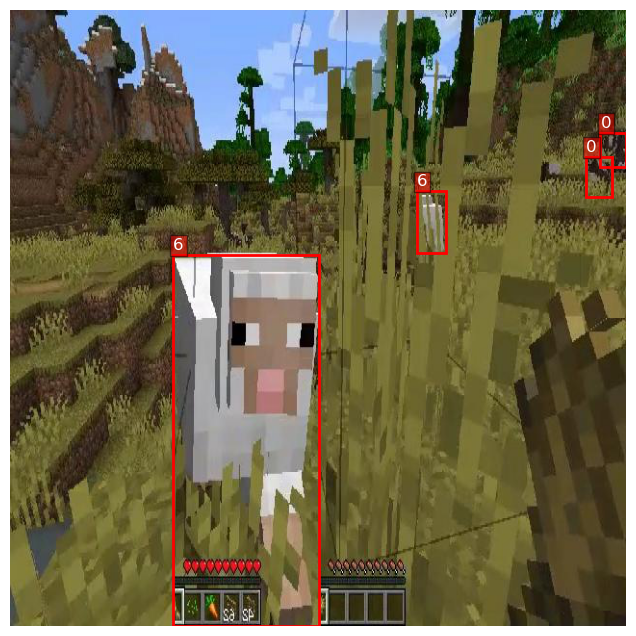

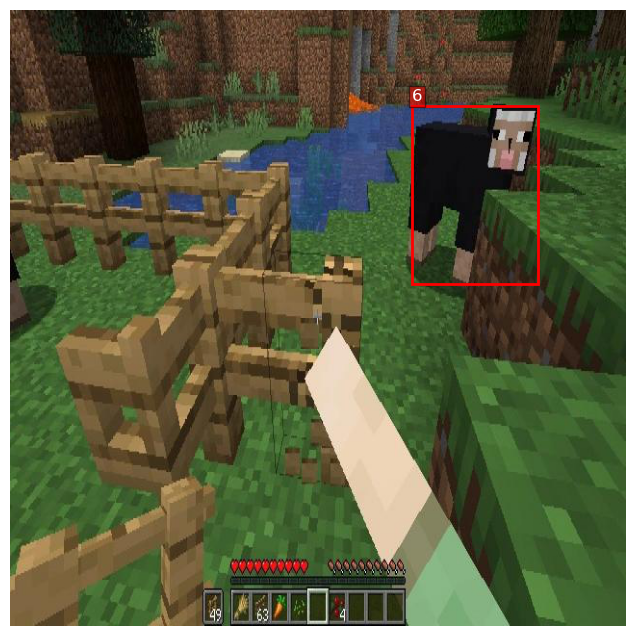

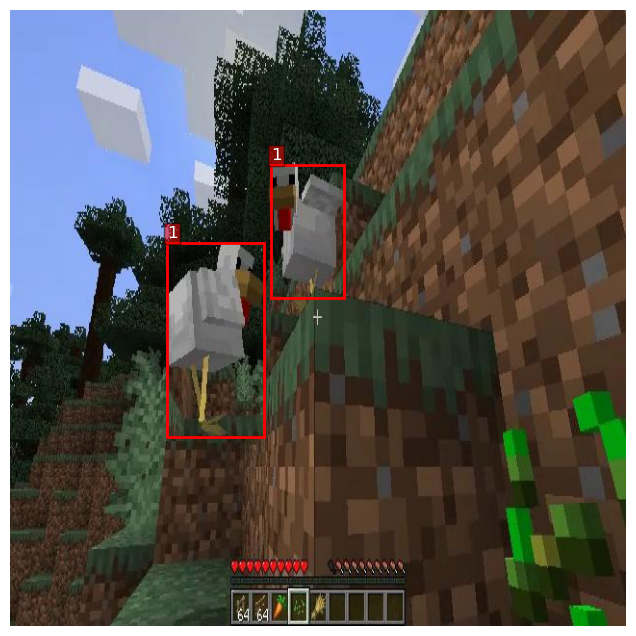

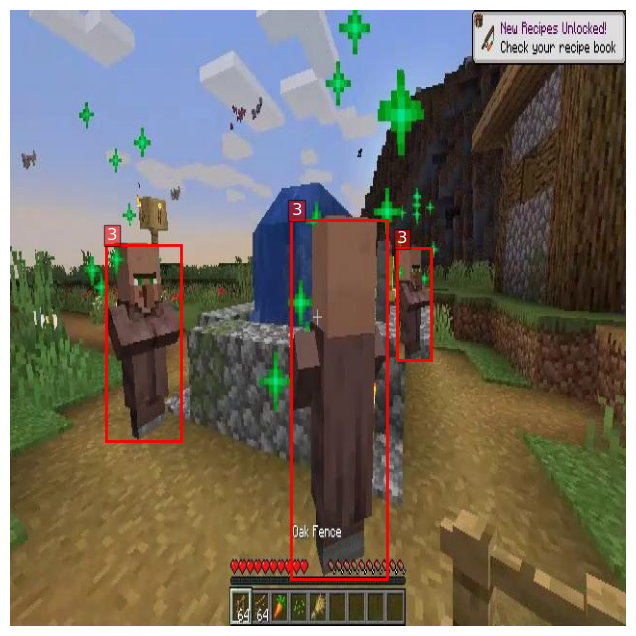

In [4]:
trainloader = data.DataLoader(mc_train, batch_size=4, shuffle=True, collate_fn=collate_fn)
images, labels = next(iter(trainloader))
for i in range(4):
    show_image_with_labels(images[i], labels[i], class_names=None)

# **Device**

In [5]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: cuda


# **Yolo V5**

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.SiLU()
        )
    def forward(self, x):
        return self.conv(x)

class FocusBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size =3, stride=1):
        super().__init__()
        self.conv = ConvBlock(in_channels * 4, out_channels, kernel_size, stride)

    def forward(self, x):
        x = torch.cat([x[:, :, ::2, ::2],
                       x[:, :, 1::2, ::2],
                       x[:, :, ::2, 1::2],
                       x[:, :, 1::2, 1::2]], dim=1)
        return self.conv(x)

class CSP(nn.Module):
    def __init__(self, in_channels, out_channels,num_blocks):
        super().__init__()
        hidden_channels = out_channels // 2
        self.conv1 = ConvBlock(in_channels, hidden_channels,1)
        self.conv2 = ConvBlock(in_channels, hidden_channels,1 )
        self.blocks = nn.Sequential(*[
            ConvBlock(hidden_channels, hidden_channels, 3)
            for _ in range(num_blocks)
        ])
        self.conv3 = ConvBlock(2*hidden_channels, out_channels,1)
    def forward(self,x):
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x1 = self.blocks(x1)
        x = torch.cat((x1, x2), dim=1)
        return self.conv3(x)


class SPPF(nn.Module):
    def __init__(self, in_channels, out_channels, k = 5):
        super().__init__()
        hidden_channels = in_channels // 2
        self.conv1 = ConvBlock(in_channels, hidden_channels,1 )
        self.conv2 = ConvBlock(hidden_channels * 4, out_channels,1)
        self.pools = nn.ModuleList([nn.MaxPool2d(kernel_size=k, stride=1, padding=k//2) for _ in range(3)])

    def forward(self, x):
        x = self.conv1(x)
        return self.conv2(torch.cat([x] + [pool(x) for pool in self.pools], 1))

class DarkNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = FocusBlock(3, 32, 3, 1)
        self.layer1 = nn.Sequential(
            ConvBlock(32, 64, 3, 2),
            CSP(64, 64,1)
        )
        self.layer2 = nn.Sequential(
            ConvBlock(64, 128, 3, 2),
            CSP(128, 128,2)
        )
        self.layer3 = nn.Sequential(
            ConvBlock(128, 256, 3, 2),
            CSP(256, 256,3)
        )
        self.layer4 = nn.Sequential(
            ConvBlock(256, 512, 3, 2),
            CSP(512, 512,1),
            SPPF(512, 1024)
        )
    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        out = self.layer2(x)
        out2 = self.layer3(out)
        out3 = self.layer4(out2)
        return out, out2, out3

class PANet(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv5_reduce = ConvBlock(1024, 512, 1)
        self.conv4_reduce = ConvBlock(256, 512, 1)
        self.csp4_td = CSP(1024, 256, num_blocks=1)

        self.conv4_reduce2 = ConvBlock(256, 128, 1)
        self.conv3_reduce = ConvBlock(128, 128, 1)
        self.csp3_td = CSP(256, 128, num_blocks=1)

        self.conv3_down = ConvBlock(128, 128, 3, stride=2)
        self.csp4_bu = CSP(384, 256, num_blocks=1)

        self.conv4_down = ConvBlock(256, 256, 3, stride=2)
        self.csp5_bu = CSP(768, 512, num_blocks=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x3, x4, x5):
        p5 = self.conv5_reduce(x5)
        p5_up = self.upsample(p5)
        p4 = self.conv4_reduce(x4)
        p4_td = self.csp4_td(torch.cat([p5_up, p4], dim=1))

        p4_red = self.conv4_reduce2(p4_td)
        p4_up = self.upsample(p4_red)
        p3 = self.conv3_reduce(x3)
        p3_td = self.csp3_td(torch.cat([p4_up, p3], dim=1))

        p3_down = self.conv3_down(p3_td)
        p4_bu = self.csp4_bu(torch.cat([p3_down, p4_td], dim=1))

        p4_down = self.conv4_down(p4_bu)
        p5_bu = self.csp5_bu(torch.cat([p4_down, p5], dim=1))

        return p3_td, p4_bu, p5_bu

    
class HeadDetection(nn.Module):
    def __init__(self, in_channels,num_classes,anchor):
        super().__init__()
        self.num_classes = num_classes
        self.anchor = anchor
        self.conv = ConvBlock(in_channels, in_channels * 2,3)
        self.final_conv = nn.Conv2d(in_channels * 2, (num_classes + 5) * anchor, kernel_size=1, stride=1, padding=0)
    def forward(self, x):
        x = self.conv(x)
        x = self.final_conv(x)
        bs, _, h, w = x.shape
        x = x.view(bs, self.anchor, self.num_classes + 5, h, w)
        return x.permute(0,1,3,4,2)

class YOLOv5(nn.Module):

    def __init__(self, num_classes, anchors = None):
        super().__init__()
        self.backbone = DarkNet()
        self.neck = PANet()
        self.num_classes = num_classes

        if anchors is None:
            self.anchors = torch.tensor([
                [[10, 13], [16, 30], [33, 23]],
                [[30, 61], [62, 45], [59, 119]],
                [[116, 90], [156, 198], [373, 326]]
            ], dtype=torch.float32)
        else:
            self.anchors = anchors
        
        self.head_small = HeadDetection(128, num_classes, 3)
        self.head_medium = HeadDetection(256, num_classes, 3)
        self.head_large = HeadDetection(512, num_classes, 3)#Ne supporte pas 512

    def forward(self, x):
        out1, out2, out3 = self.backbone(x)
        new_out1, new_out2, new_out3 = self.neck(out1, out2, out3)
        y_small = self.head_small(new_out1)
        y_medium = self.head_medium(new_out2)
        y_large = self.head_large(new_out3)
        return [y_small, y_medium, y_large]



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLOv5(num_classes=classes_number).to(device)

summary(model, (3, 640, 640), device=str(device))


from torchviz import make_dot

params = {name: param for name, param in model.named_parameters() if isinstance(param, torch.Tensor)}

x = torch.randn(1, 3, 640, 640).to(device)
y = model(x)

make_dot(y[0], params=dict(model.named_parameters())).render("yolov5_arch", format="png")



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 320, 320]           3,456
       BatchNorm2d-2         [-1, 32, 320, 320]              64
              SiLU-3         [-1, 32, 320, 320]               0
         ConvBlock-4         [-1, 32, 320, 320]               0
        FocusBlock-5         [-1, 32, 320, 320]               0
            Conv2d-6         [-1, 64, 160, 160]          18,432
       BatchNorm2d-7         [-1, 64, 160, 160]             128
              SiLU-8         [-1, 64, 160, 160]               0
         ConvBlock-9         [-1, 64, 160, 160]               0
           Conv2d-10         [-1, 32, 160, 160]           2,048
      BatchNorm2d-11         [-1, 32, 160, 160]              64
             SiLU-12         [-1, 32, 160, 160]               0
        ConvBlock-13         [-1, 32, 160, 160]               0
           Conv2d-14         [-1, 32, 1

'yolov5_arch.png'

In [ ]:
model = YOLOv5(num_classes=classes_number).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [77]:

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(trainloader):
        print(type(labels), type(images))
        images = images.to(device)
        labels = [label.to(device) for label in labels]
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs.view(-1, model.output_size), torch.cat(labels).view(-1, model.output_size))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}")
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"yolo_epoch_{epoch + 1}.pth")
        print(f"Model saved at epoch {epoch + 1}")

    model.eval()
    with torch.no_grad():
        test_images, test_labels = next(iter(trainloader))
        test_images = test_images.to(device)
        outputs = model(test_images)
        loss = criterion(outputs.view(-1, model.output_size), torch.cat(test_labels).view(-1, model.output_size))
        print(f"Validation Loss: {loss.item():.4f}")

<class 'tuple'> <class 'torch.Tensor'>


AttributeError: 'YoloV3' object has no attribute 'output_size'